# Modern DiD Approaches



In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pyfixest as pf

import warnings
warnings.simplefilter('ignore')

%config InlineBackend.figure_format = "retina"

The data is from [Callaway (2022)](https://bcallaway11.github.io/files/Callaway-Chapter-2022/main.pdf), annual county level data from the United States covering 2001 to 2007. The outcome variable is log county-level teen employment, and the treatment variable is an indicator for whether the county has a minimum wage above the federal minimum wage. See [Callaway and Sant’Anna (2021)](https://www.sciencedirect.com/science/article/abs/pii/S0304407620303948) for additional details on the data.

In [31]:
url = "https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/data/minwage_data.csv"
data = pd.read_csv(url,index_col=0)

# Remove observations that are already treated in the first observed period (2001).
data = data.loc[(data.G == 0) | (data.G > 2001)].reset_index()

# Drop all variables that we won't use
data.drop(columns=["countyreal", "state_name", "FIPS", "emp0A01_BS",
                   "quarter", "censusdiv", "pop", "annual_avg_pay",
                   "state_mw", "fed_mw", "ever_treated"], inplace=True)

data.head(10)

,index,year,treated,G,lemp,lpop,lavg_pay,region,id
0,554,2001,0,2007,5.556828,9.614137,10.057495,4,8003
1,555,2002,0,2007,5.356586,9.623972,10.097120,4,8003
2,556,2003,0,2007,5.389072,9.620859,10.107611,4,8003
3,557,2004,0,2007,5.356586,9.626548,10.140337,4,8003
4,558,2005,0,2007,5.303305,9.637958,10.175497,4,8003
5,559,2006,0,2007,5.342334,9.633056,10.218590,4,8003
6,560,2007,1,2007,5.220356,9.635412,10.289702,4,8003
7,561,2001,0,2007,5.198497,9.260368,10.021359,4,8007
8,562,2002,0,2007,5.262690,9.312265,10.031045,4,8007
9,563,2003,0,2007,5.278115,9.338118,10.071795,4,8007


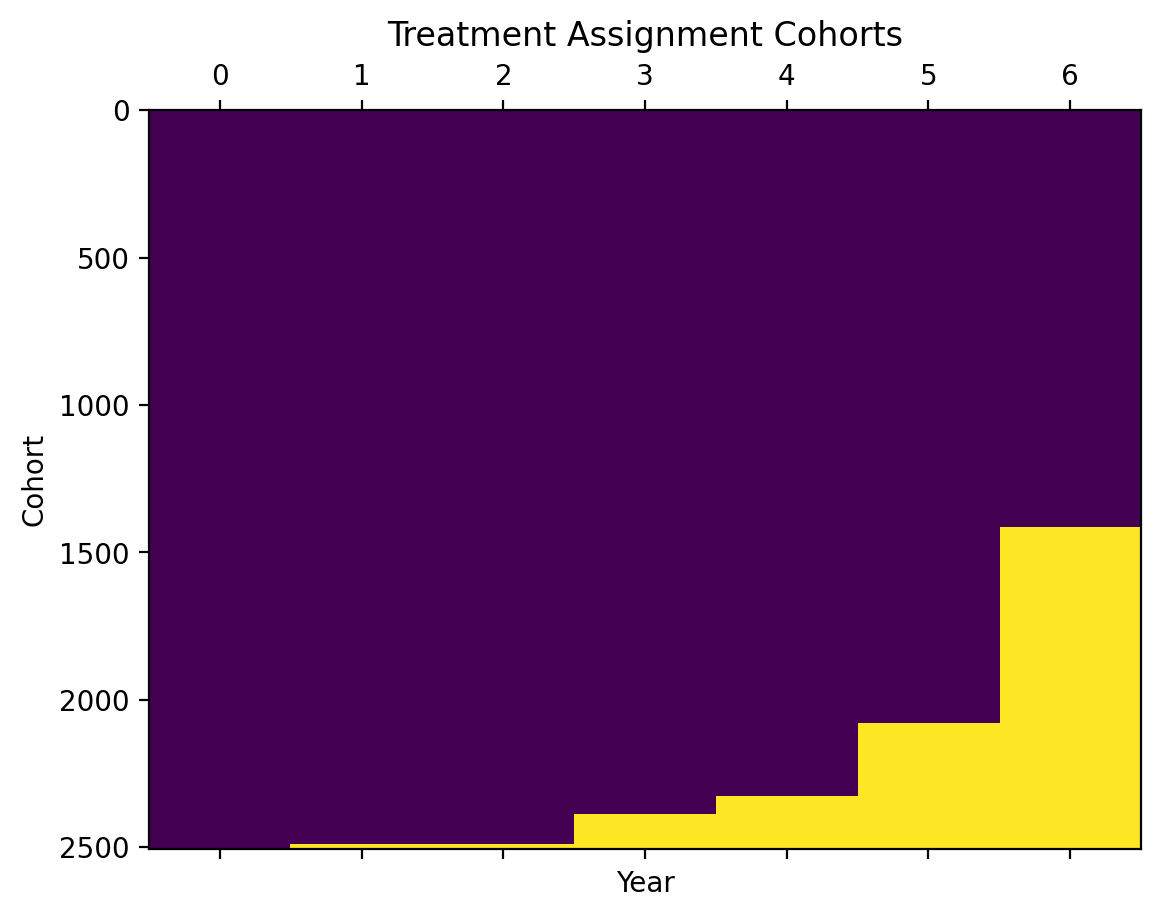

In [32]:
pf.panelview(
    data,
    unit="id",
    time="year",
    treat="treated",
    sort_by_timing=True,
    ylab="Cohort",
    xlab="Year",
    title="Treatment Assignment Cohorts",
    figsize=(0.5, 0.5),
)

plt.show()

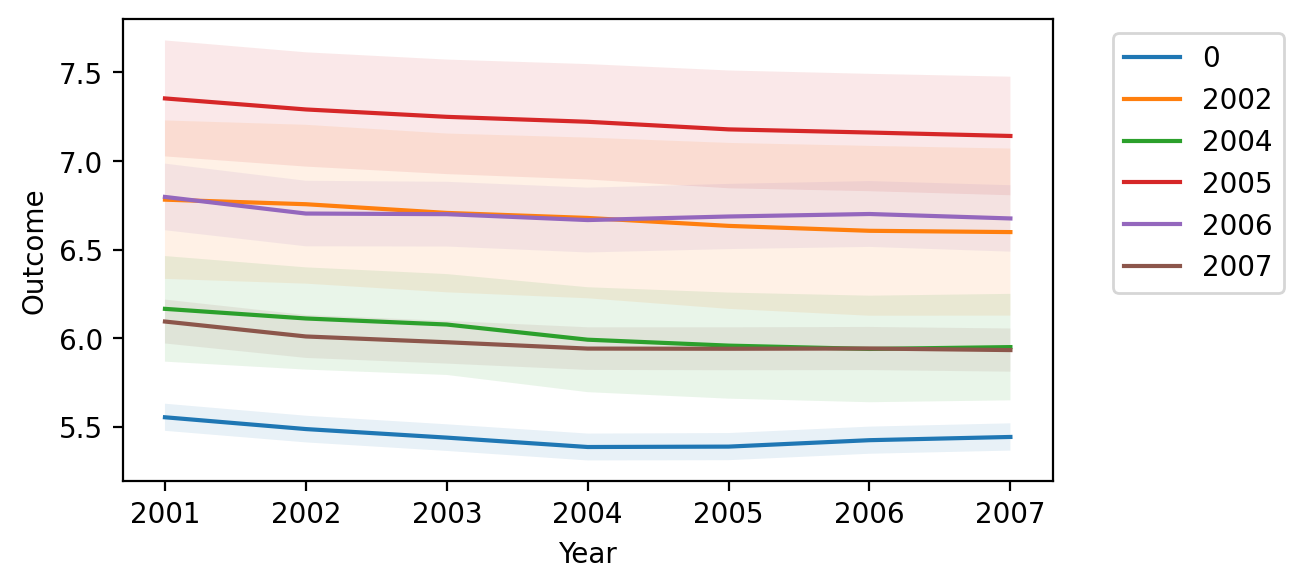

In [33]:
fig, ax = plt.subplots(figsize=(6, 3))

# Calculate means and standard errors
means = data.groupby(["year", "G"])["lemp"].mean().unstack()
std_errors = data.groupby(["year", "G"])["lemp"].sem().unstack()

# Plot means
means.plot(ax=ax)

# Add standard errors using for loop
for group in means.columns:
    ax.fill_between(means.index, means[group] - 1.96 * std_errors[group], means[group] + 1.96 * std_errors[group], alpha=0.1)

# Add legend, vertical line, labels, and show plot
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
plt.xlabel("Year")
plt.ylabel("Outcome")
plt.show()

Even though we know the problems of using TWFE with staggered adoption, we will use it as a benchmark to compare with the other methods.

In [34]:
data['relative_year'] = np.where(data['G'] > 0, data['year'] - data['G'], -np.inf)

fit_twfe = pf.feols("lemp ~ i(relative_year, ref=-1.0) | id + year",
                    data, vcov={"CRV1": "id"})

fit_twfe.iplot(
    coord_flip=False,
    title="TWFE-Estimator",
    figsize=[800, 300],
    xintercept=4.5,
    yintercept=0,
    joint=True,
    labels=pf.report.utils.rename_event_study_coefs(fit_twfe._coefnames),  # rename coefficients
).show()

## Callaway and Sant'Anna (2020)

CS propose two ways of dealing with the negative weights. 

1. Compare average outcomes in any post-adoption period $(\bar{Y}_{t \mid a} \text{ for } t \geq a)$ to average outcomes for the same group immediately prior to the adoption $(\bar{Y}_{a-1 \mid a})$. Then, subtract the difference in outcomes for the same two time periods for the single group that never adopts the treatment $(a=\infty)$. Formally, for $t \geq a$, this double difference is
$$
\hat{\tau}_{t, a-1}^{a, \infty}=\left(\bar{Y}_{t \mid a}-\bar{Y}_{a-1 \mid a}\right)-\left(\bar{Y}_{t \mid \infty}-\bar{Y}_{a-1 \mid \infty}\right) .
$$

2. Same as above, but instead of using the group that never adopts the treatment as the control group, use the average of the groups that do adopt the treatment, but restrict this to those who adopt after period $t$. 
$$
\hat{\tau}_{t, a-1}^{a,>t} \equiv\left(\bar{Y}_{t \mid a}-\bar{Y}_{a-1 \mid a}\right)-\frac{1}{T-t} \sum_{a^{\prime}=t+1}^T\left(\bar{Y}_{t \mid a^{\prime}}-\bar{Y}_{a-1 \mid a^{\prime}}\right)
$$

3. Given these two estimators, CS suggest reporting averages over periods $t$ and adoption dates $a$, using a variety of possible weight functions $\omega(a, t)$. This leads to an average of treatment effects, over different adoption dates, at exactly $e$ periods after adoption, for their two control groups,
$$
\hat{\tau}^{\mathrm{CS}, \mathrm{I}}(e)=\sum_{a=2}^{T-e} \omega_e(a, t) \cdot \hat{\tau}_{t, a-1}^{a, \infty}, \quad \text { or } \quad \hat{\tau}^{\mathrm{CS}, \mathrm{II}}(e)=\sum_{a=2}^{T-e} \omega_e(a, t) \cdot \hat{\tau}_{t, a-1}^{a,>t} .
$$

A concern is that the control group that never adopts the treatment might be fundamentally different from the other groups and thus less suitable as a comparison for the trends in the absence of the treatment.

In [35]:
from csdid.att_gt import ATTgt

# estimate group-time average treatment effects without covariates
attgt = ATTgt(yname="lemp", gname="G", idname="id", tname="year",
              xformla=f"lemp~1", data=data).fit()
attgt.summ_attgt().summary2

,Group,Time,"ATT(g, t)",Post,Std. Error,[95% Pointwise,Conf. Band],
0,2002,2002,0.0408,1,0.0128,0.0027,0.0790,*
1,2002,2003,0.0400,1,0.0234,-0.0298,0.1098,
2,2002,2004,0.0646,1,0.0239,-0.0068,0.1361,
3,2002,2005,0.0176,1,0.0350,-0.0868,0.1220,
4,2002,2006,-0.0464,1,0.0460,-0.1836,0.0908,
5,2002,2007,-0.0718,1,0.0351,-0.1765,0.0328,
6,2004,2002,0.0122,0,0.0192,-0.0450,0.0695,
7,2004,2003,0.0142,0,0.0179,-0.0394,0.0677,
8,2004,2004,-0.0327,1,0.0266,-0.1122,0.0468,
9,2004,2005,-0.0683,1,0.0270,-0.1488,0.0122,


Under the no-anticipation and parallel trends assumptions, group-time average treatment effects are identified in periods when $t \geq g$ (i.e., post-treatment periods for each group). 

The table also reports pseudo group-time average treatment effects when $t < g$ (i.e., pre-treatment periods for group $g$).

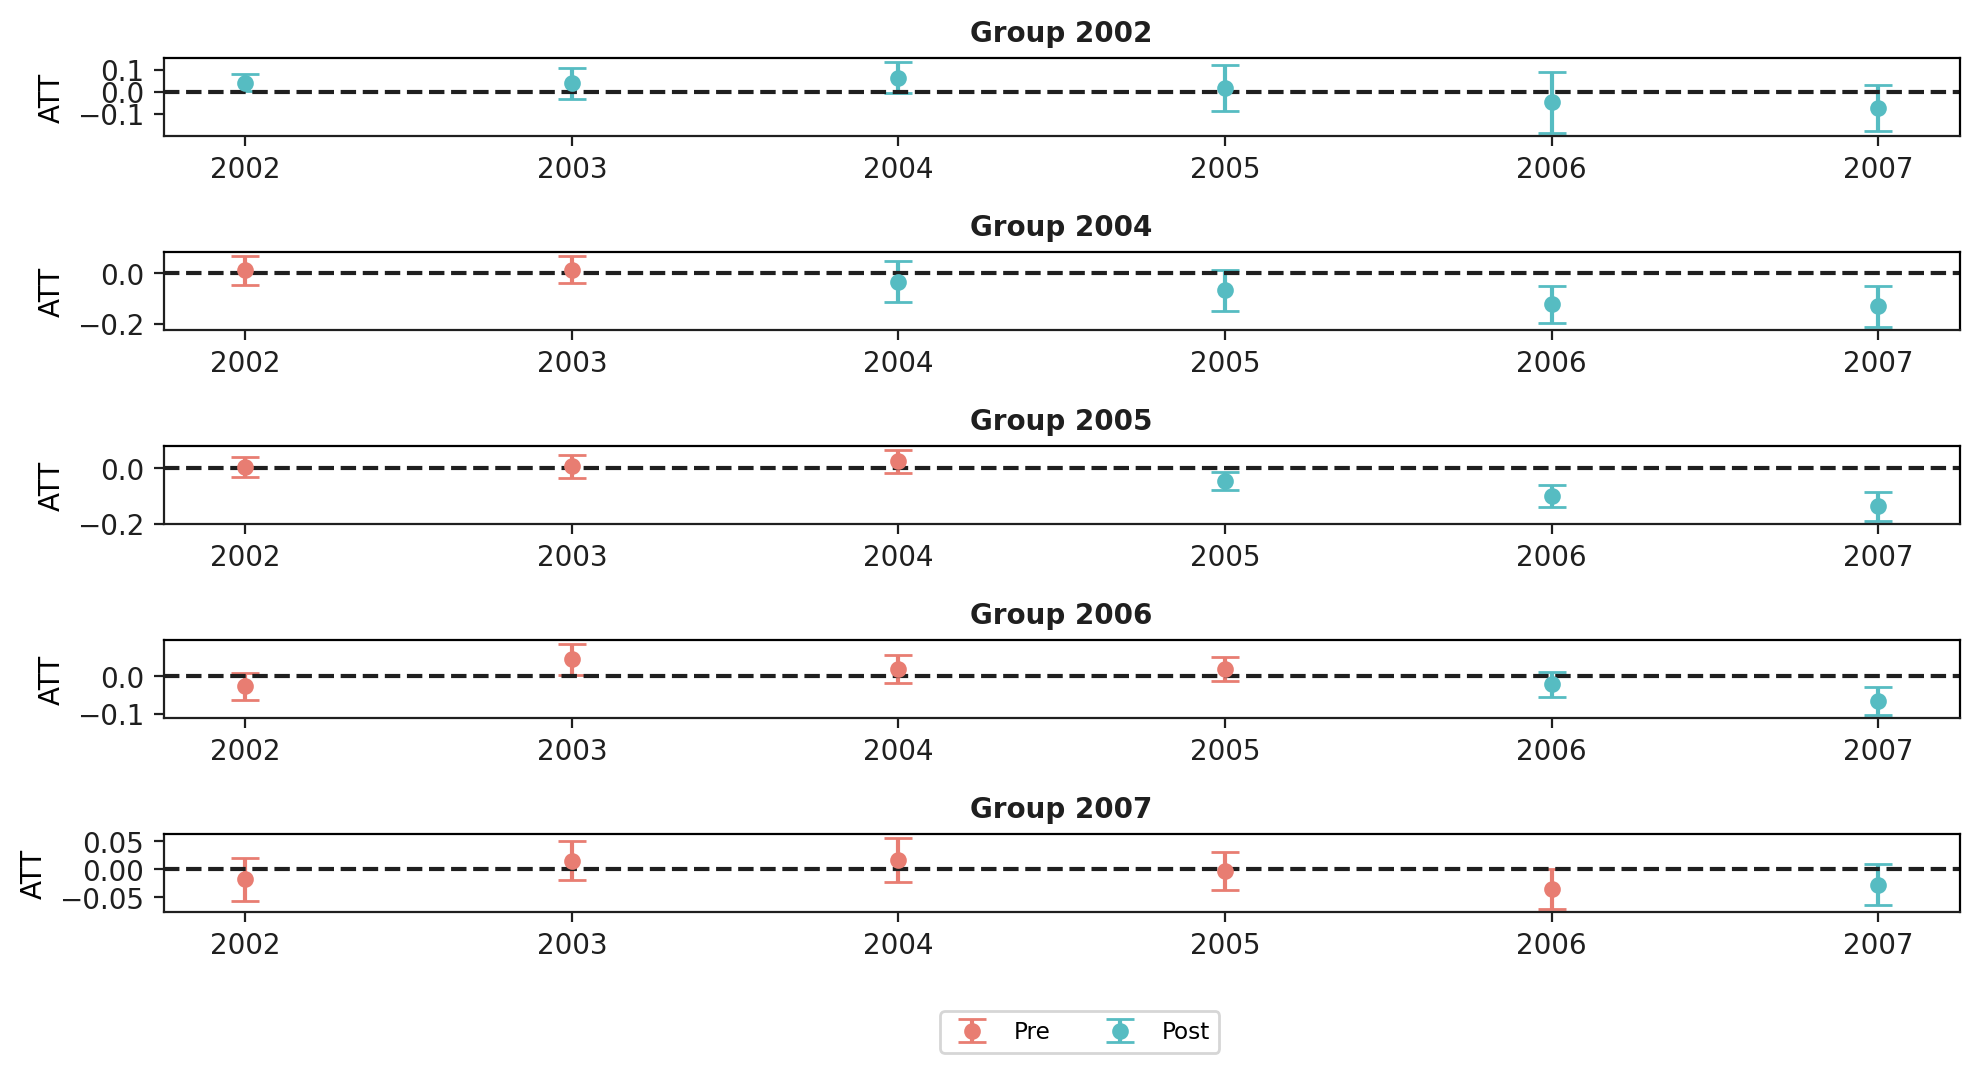

In [36]:
attgt.plot_attgt();

The resulting figure is one that contains separate plots for each group. Each figure contains estimates of group-time average treatment effects for each group in each time period along with a simultaneous confidence interval. 

The red dots in the plots are pre-treatment pseudo group-time average treatment effects and the blue dots are post-treatment group-time average treatment effects and should be interpreted as the average effect of raising minimum wage above federal levels for counties in a particular group at a particular point in time.

In [37]:
attgt.aggte("simple");



    ATT Std. Error  [95.0%  Conf. Int.]  
-0.0501     0.0074 -0.0646      -0.0356 *


---
Signif. codes: `*' confidence band does not cover 0
Control Group:  Never Treated , 
Anticipation Periods:  0
Estimation Method:  Doubly Robust




This is a weighted average of all group-time average treatment effects with weights proportional to the group size. In this case, there is a negative effect of raising the minimum wage above federal levels on teen employment.

However, this `simple` aggregation tends to overweight the effect of early-treated groups simply because we observe more of them during post-treatment periods.



Overall summary of ATT's based on group/cohort aggregation:
    ATT Std. Error  [95.0%  Conf. Int.]  
-0.0399     0.0085 -0.0567      -0.0232 *


Group Effects:
   Group  Estimate  Std. Error  [95.0% Simult.   Conf. Band   
0   2002    0.0075      0.0256          -0.0428      0.0577   
1   2004   -0.0888      0.0217          -0.1314     -0.0463  *
2   2005   -0.0937      0.0117          -0.1165     -0.0708  *
3   2006   -0.0439      0.0101          -0.0636     -0.0241  *
4   2007   -0.0271      0.0111          -0.0488     -0.0053  *
---
Signif. codes: `*' confidence band does not cover 0
Control Group:  Never Treated , 
Anticipation Periods:  0
Estimation Method:  Doubly Robust




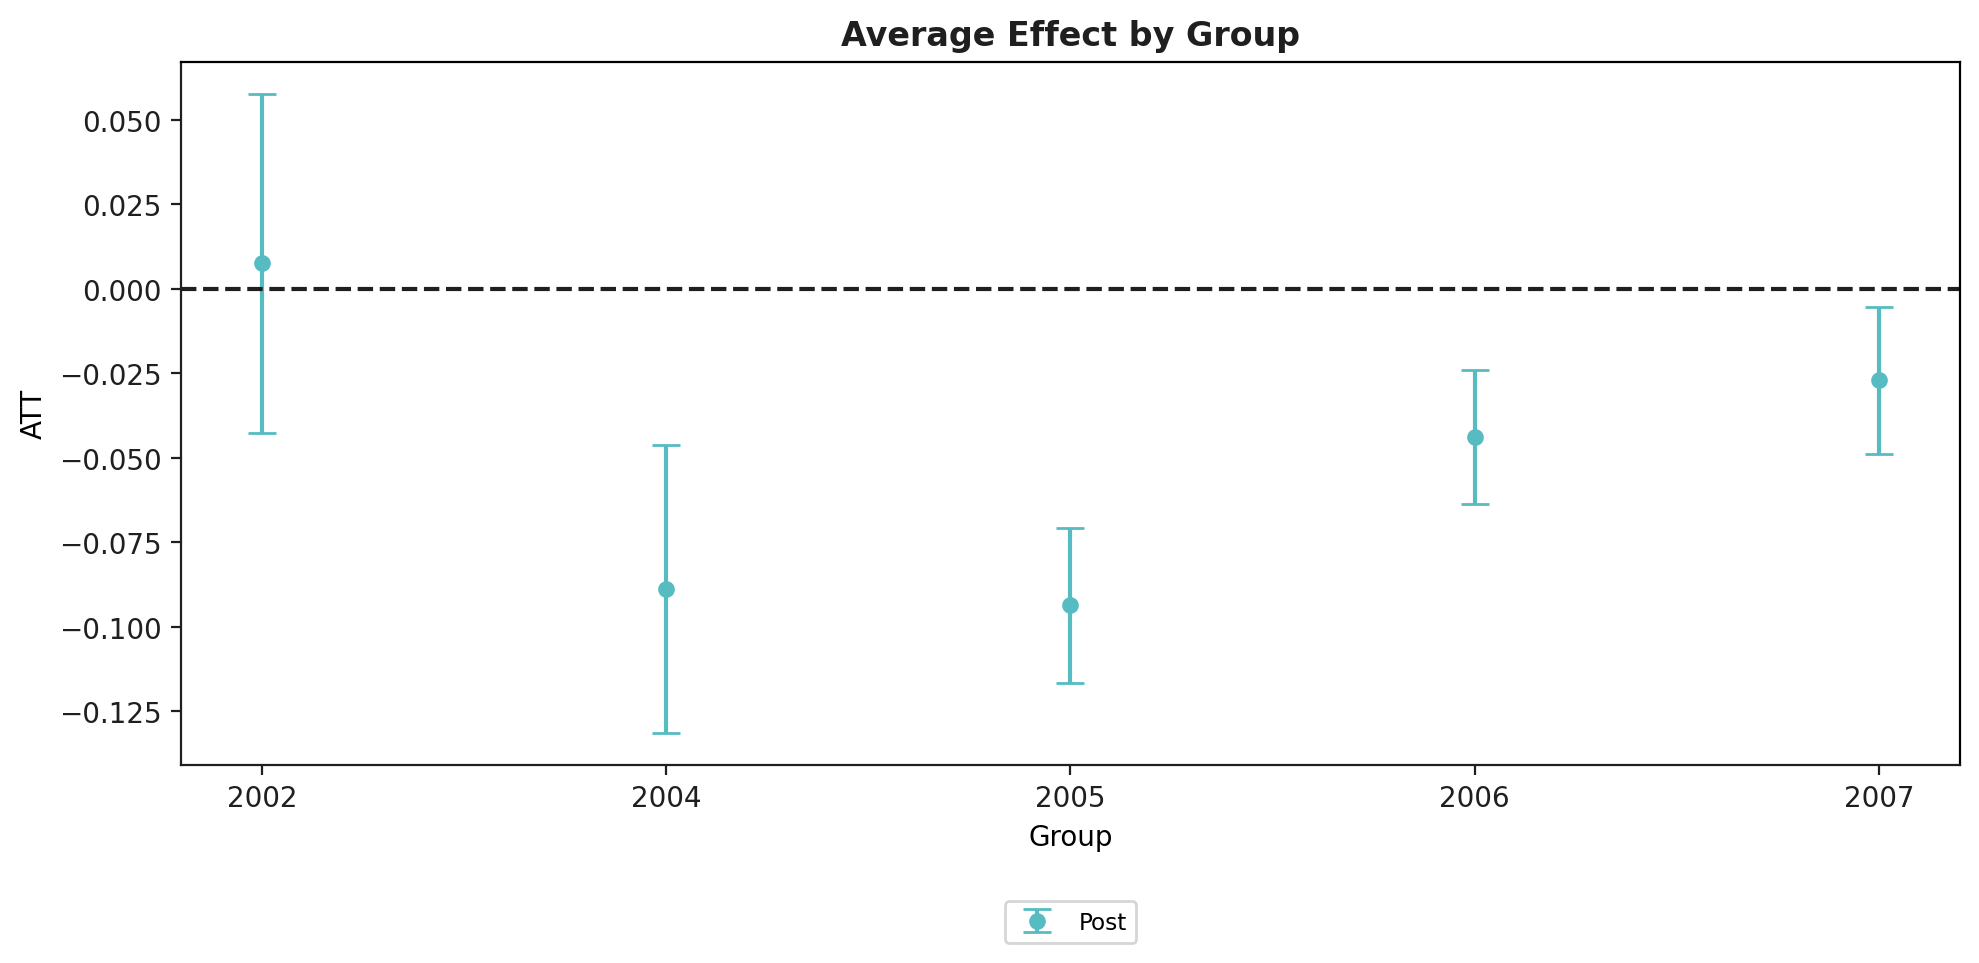

In [38]:
attgt.aggte("group")
attgt.plot_aggte();

Average effects specific to each group: The figure shows the average effect of raising the minimum wage above federal levels on teen employment for each group of treated counties.

For counties treated in 2004 and 2005, the effect is almost as twice as large as the effect for counties treated in 2006 and 2007.

According to CS, this parameter is the leading choice as an overall summary effect of participating in the treatment. 

What happen if we introduce covariates? And what if we use the not-yet-adopted group as control group?

In [39]:
attgt_altcontrol = ATTgt(yname="lemp", gname="G", idname="id", tname="year",
                         xformla=f"lemp~lpop+lavg_pay", data=data).fit()
attgt_altcontrol.summ_attgt().summary2

,Group,Time,"ATT(g, t)",Post,Std. Error,[95% Pointwise,Conf. Band],
0,2002,2002,0.0408,1,0.0142,-0.0007,0.0824,
1,2002,2003,0.0400,1,0.0250,-0.0331,0.1131,
2,2002,2004,0.0646,1,0.0244,-0.0069,0.1362,
3,2002,2005,0.0176,1,0.0333,-0.0799,0.1151,
4,2002,2006,-0.0464,1,0.0417,-0.1686,0.0757,
5,2002,2007,-0.0718,1,0.0338,-0.1708,0.0271,
6,2004,2002,0.0122,0,0.0184,-0.0415,0.0660,
7,2004,2003,0.0142,0,0.0173,-0.0366,0.0650,
8,2004,2004,-0.0327,1,0.0258,-0.1081,0.0428,
9,2004,2005,-0.0683,1,0.0265,-0.1459,0.0093,




Overall summary of ATT's based on group/cohort aggregation:
    ATT Std. Error  [95.0%  Conf. Int.]  
-0.0399     0.0082 -0.0559       -0.024 *


Group Effects:
   Group  Estimate  Std. Error  [95.0% Simult.   Conf. Band   
0   2002    0.0075      0.0260          -0.0435      0.0585   
1   2004   -0.0888      0.0231          -0.1341     -0.0436  *
2   2005   -0.0937      0.0109          -0.1151     -0.0723  *
3   2006   -0.0439      0.0096          -0.0626     -0.0251  *
4   2007   -0.0271      0.0117          -0.0500     -0.0042  *
---
Signif. codes: `*' confidence band does not cover 0
Control Group:  Never Treated , 
Anticipation Periods:  0
Estimation Method:  Doubly Robust




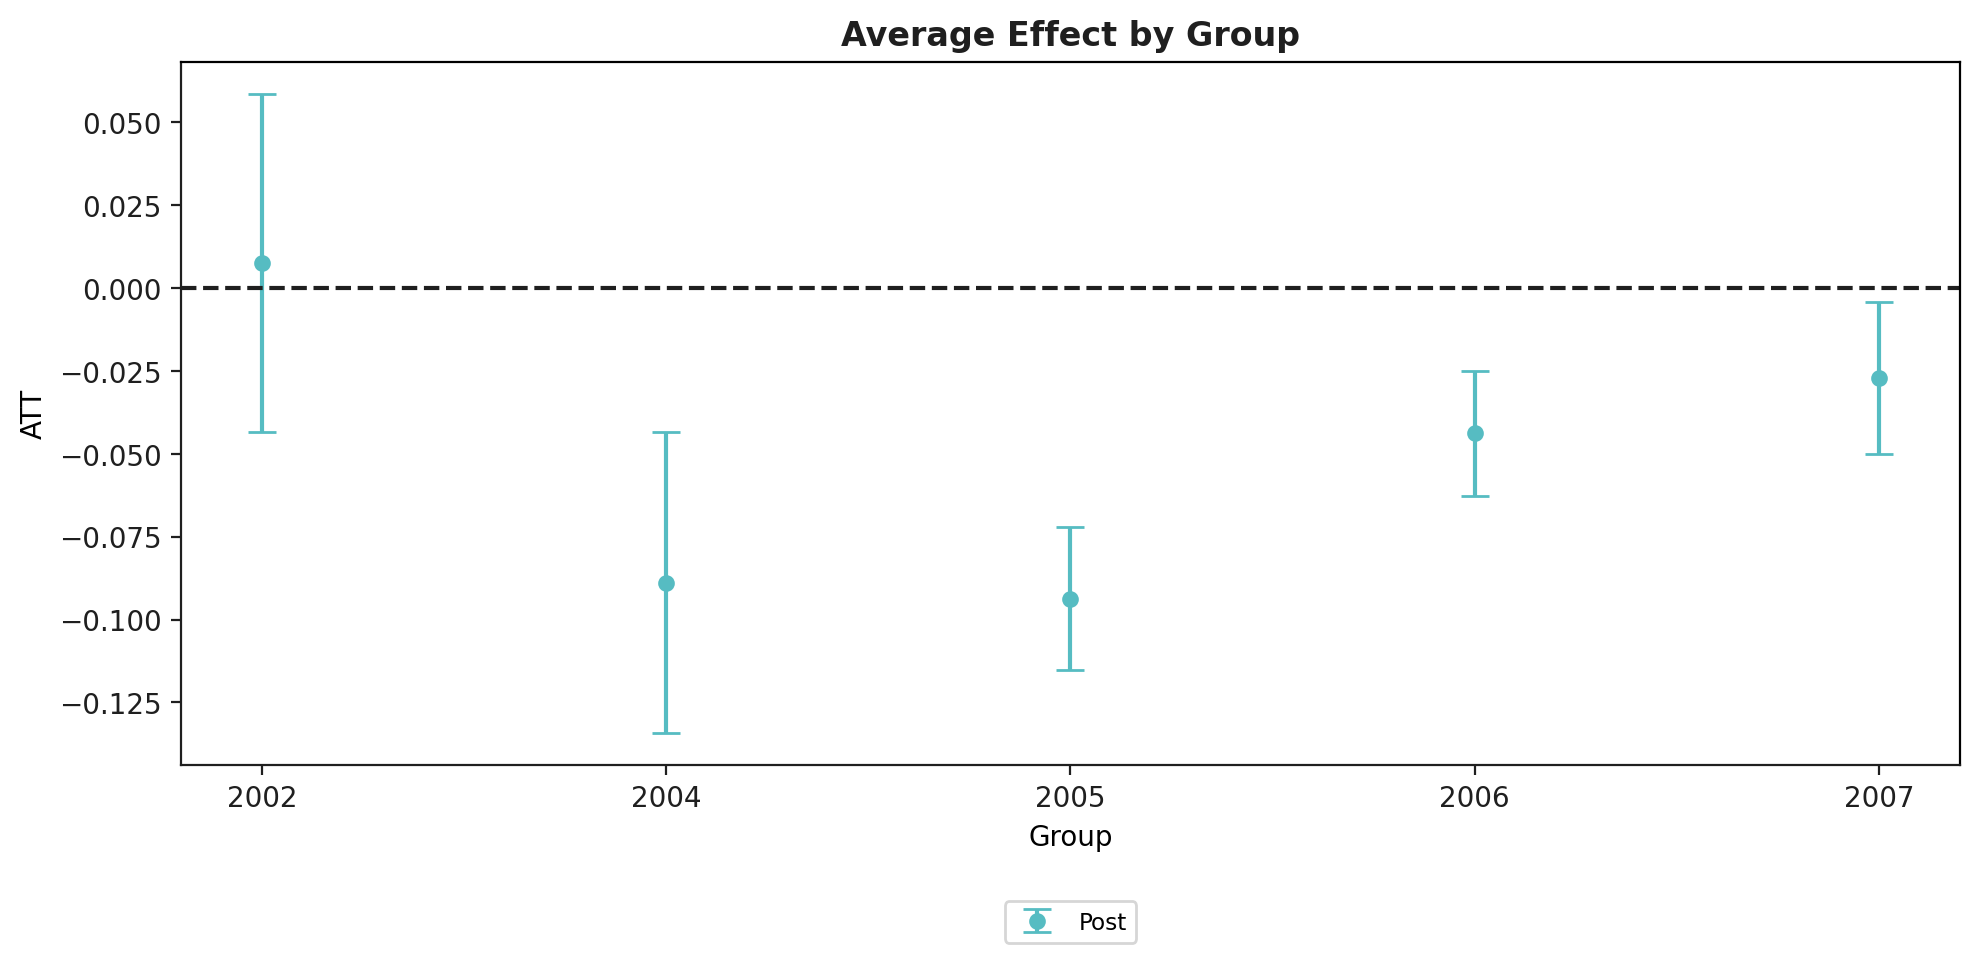

In [40]:
attgt_altcontrol.aggte("group")
attgt_altcontrol.plot_aggte();

In [43]:
attgt_altcontrol = ATTgt(yname="lemp", gname="G", idname="id", tname="year",
                         control_group="notyettreated", data=data).fit()
attgt_altcontrol.summ_attgt().summary2

IndexError: index 2002 is out of bounds for axis 0 with size 5